[실습] 신용 카드 고객 데이터 분석과 신용도 예측

### 데이터 분석 목적
    - 신용카드 발급을 희망하는 소비자 데이터를 분석하고 카드 발급 여부 결정을 위한 의사 결정 모델을 분석한다.
    - 신용불량자를 판별하여 신용카드 비즈니스 영업 이익률을 개선시킨다.

   
### Key Point
    - 데이터 처리(join, target label 선정) 방법에 대해 배운다
    - 데이터 유형별 EDA와 insight를 얻는 방법에 대해 배운다
    - categorical data 결측치를 처리하는 방법을 배운다
    - mlflow를 활용해서 모델을 selection하고 serving 한다. 



In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 8.0 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 7.9 MB/s eta 0:00:0000:0100:01


In [7]:
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 1.9 MB/s eta 0:00:00a 0:00:01


In [1]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
#import pandas_profiling
from datetime import datetime
import random

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency, kruskal
from scipy.stats import boxcox, norm
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols

# library for sampling
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

# library for machine learning
import sklearn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import shap
%matplotlib inline

## 1. Data Processing 1

### 1-1 Data Load

In [2]:
!pwd
path_lecture = "./"
random_state = 1234

/Users/a202304035/MLOPS_ProdML/mlflow_project/credit_approval_prediction


In [3]:
df = pd.read_csv(path_lecture + "data/application_record.csv")
df_record = pd.read_csv(path_lecture + "data/credit_record.csv")
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
df_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
df_record.sort_values(["ID", "MONTHS_BALANCE"], ascending=False).groupby("ID").first()

,MONTHS_BALANCE,STATUS
ID,,
5001711,0,X
5001712,0,C
5001713,0,X
5001714,0,X
5001715,0,X
...,...,...
5150482,-11,C
5150483,0,X
5150484,0,C


### 1-2 Duplicated Data 확인

1. 데이터를 내가 수집
2. 남의 데이터 활용

In [6]:
print("중복된 항목 수 :", len(df[df.duplicated()]))
print("중복된 항목 수 :", len(df_record[df_record.duplicated()]))

중복된 항목 수 : 0
중복된 항목 수 : 0


### 1-3 Data Join

In [7]:
len(df)

438557

In [8]:
# To do
# ID를 기준으로 inner join을 진행 
df.merge(df_record, on='ID', how='inner')

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777710,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-9,0
777711,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-10,2
777712,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-11,1
777713,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-12,0


In [9]:
len(df.merge(df_record, on="ID", how="inner"))

777715

In [10]:
# df는 438557인데, join후에 777715 개가 됨 -> df_record에 ID별 data가 1개 이상인 경우가 있음을 의미
print(len(df_record))
print(df_record.ID.nunique())

1048575
45985


In [11]:
# df_record에서 가장 최근 데이터 만을 선택. 0이 현재며 -1일때마다 1달씩 과거 시점의 데이터.
# -1은 한 달전 데이터, -10은 10개월전 데이터
df_record.MONTHS_BALANCE.unique()

array([  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12,
       -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25,
       -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38,
       -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51,
       -52, -53, -54, -55, -56, -57, -58, -59, -60])

In [12]:
# To do 
# ID별 가장 최신의 데이터만 선택
df_record_filtered = df_record.sort_values(["ID", "MONTHS_BALANCE"], ascending=False).groupby("ID").first()
df_record_filtered

,MONTHS_BALANCE,STATUS
ID,,
5001711,0,X
5001712,0,C
5001713,0,X
5001714,0,X
5001715,0,X
...,...,...
5150482,-11,C
5150483,0,X
5150484,0,C


In [13]:
# target 데이터가 없는 데이터들은 학습할 수 없으므로 제거 -> join을 활용해서 제거할 수 있음
# semi-supervised learning이라는 기법이 있어, target 데이터가 없는 데이터를 같이 활용할 수 있는 방법이 있음 -> 하지만, 이번 강의에서는 다루지 않기 때문에 skip
df = df.merge(df_record_filtered, on="ID", how="inner")

In [14]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,C
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-22,X


In [15]:
len(df)

36457

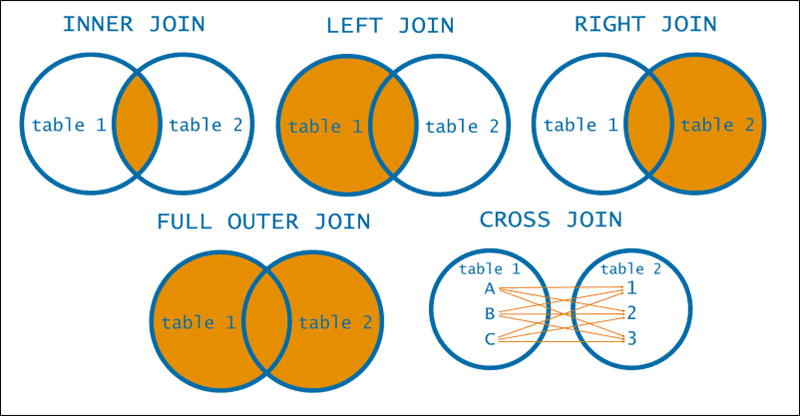

In [16]:
Image(path_lecture+"img/jointypes.png")

### 1-4 Dependent(종속) Data 선정
*   본 데이터의 Target은 의사 결정권자가 선택이 필요함
*   어느 정도의 신용 STATUS에 대해서 신용카드 발급 승인을 내릴 지를 검토 필요
*   **본 실습에서는 연체가 없는 고객들에 대해서만 신용카드 발급 승인을 내려주는 것으로 데이터 분석 진행**



In [17]:
df.STATUS.unique()

array(['C', '0', 'X', '1', '5', '3', '4', '2'], dtype=object)

In [18]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,C
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-22,X


In [19]:
condition_no_approval = df.STATUS.isin(["0","1","2","3","4","5"])

In [20]:
df["Target_Status"] = None

df.loc[condition_no_approval,"Target_Status"] = 0 # 신용도 안좋음
df.loc[~condition_no_approval, "Target_Status"] = 1 # 신용도가 좋음 

In [21]:
df.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Target_Status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,0,C,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,0,C,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,0,C,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,0,0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-22,X,1


In [22]:
# 기존 STATUS 제거
df = df.drop("STATUS", axis=1)

In [23]:
df["Target_Status"].value_counts()

Target_Status
1    27619
0     8838
Name: count, dtype: int64

## 2. Data EDA

### 2-1 Data Type and Summary

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [25]:
df.isna().sum().sort_values(ascending=False)

OCCUPATION_TYPE        11323
ID                         0
CODE_GENDER                0
MONTHS_BALANCE             0
CNT_FAM_MEMBERS            0
FLAG_EMAIL                 0
FLAG_PHONE                 0
FLAG_WORK_PHONE            0
FLAG_MOBIL                 0
DAYS_EMPLOYED              0
DAYS_BIRTH                 0
NAME_HOUSING_TYPE          0
NAME_FAMILY_STATUS         0
NAME_EDUCATION_TYPE        0
NAME_INCOME_TYPE           0
AMT_INCOME_TOTAL           0
CNT_CHILDREN               0
FLAG_OWN_REALTY            0
FLAG_OWN_CAR               0
Target_Status              0
dtype: int64

In [26]:
# categorical and numeric columns
for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].unique())

ID int64 [5008804 5008805 5008806 ... 5149838 5150049 5150337]
CODE_GENDER object ['M' 'F']
FLAG_OWN_CAR object ['Y' 'N']
FLAG_OWN_REALTY object ['Y' 'N']
CNT_CHILDREN int64 [ 0  1  3  2  4  5 14 19  7]
AMT_INCOME_TOTAL float64 [ 427500.   112500.   270000.   283500.   135000.   130500.   157500.
  405000.   211500.   360000.   126000.   315000.   247500.   297000.
  225000.   166500.   216000.   255150.   148500.   202500.    94500.
  450000.   180000.    90000.   765000.   382500.   144000.   229500.
  292500.    74250.    40500.   337500.   193500.   267750.   139500.
   67500.   252000.   900000.   115290.   279000.    76500.   234000.
   81000.   108000.    99000.   198000.    45000.   238500.   117000.
  153000.  1350000.   445500.   495000.    85500.   306000.   562500.
  189000.   328500.   310500.   540000.   171000.   675000.   121500.
   72000.    65250.   184500.   103500.   162000.   165150.    54000.
  243000.   256500.    33300.   697500.   101250.    58500.   110250.
  

In [27]:
# To do 
# casting categorical columns as object type 
list_cast_object = ["ID",'FLAG_MOBIL', "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL"]

for column_name in list_cast_object:
    df[column_name] = df[column_name].astype(object)

In [28]:
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['float64','int64']).columns)
target_column = "Target_Status"
print(len(df))
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

36457
20
14
6


#### Summary of Data Set
##### - Number of Variables : 20
    numeric variables : 6
    categorical variables : 14 (target 포함)
##### - Number of observations : 36457
##### - Missing Cells : 1 columns (OCCUPATION_TYPE)
##### - Duplicated Rows : 0

### 2-2 Dependent(종속) Data Explore

In [29]:
##### to do #####
# list_cateogircal에서 target_column제거

list_categorical_columns.remove(target_column)

In [30]:
##### to do #####

df[target_column].describe()

count     36457
unique        2
top           1
freq      27619
Name: Target_Status, dtype: int64

<Axes: xlabel='Target_Status', ylabel='count'>

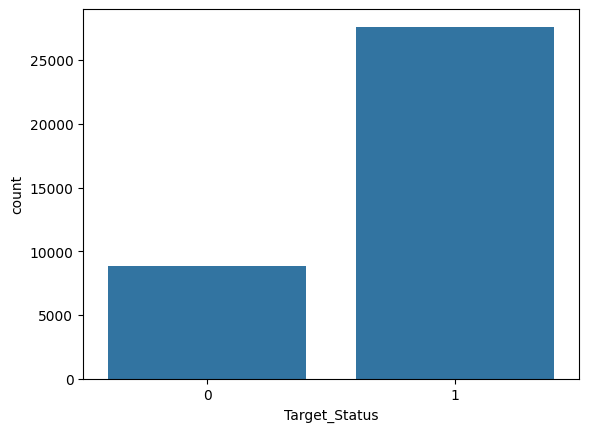

In [31]:
##### to do #####
sns.countplot(x=target_column, data=df)


#### Imbalance data set?
  - 두 개 target class 비중 차이가 있다. 독립 변수가 categorical 이 포함된 경우는 one-hot encoding을 진행한 뒤에 sampling(oversampling 혹은 undersampling) 을 해야 한다.
  - 1 속성인 데이터들이 유의미한 데이터 분포와 특성을 갖는다면, 추가적인 sampling 없이 모델 학습이 잘 될 수 있다.
  - ML 학습시 cost-sensitive (class weight 등)을 활용할 수 있다.

##### 1. 데이터 기반 접근 방법
    - Sampling (over sampling)
    (이번 실습에서는 oversampling sampling 중에서 SMOTE 활용)
    https://imbalanced-learn.org/stable/references/index.html#api
##### 2. ML 알고리즘 기반 접근 방법
    - ML 알고리즘 활용 -> ML 학습 시에 class weight를 활용하여 cost-sensitive learning
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### 2-3 Independent(독립) Data Explore

#### 1) Categorical Data Analysis

##### 불필요한 컬럼 확인

In [32]:
df[list_categorical_columns].nunique().sort_values()


FLAG_MOBIL                 1
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
FLAG_WORK_PHONE            2
FLAG_PHONE                 2
FLAG_EMAIL                 2
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
OCCUPATION_TYPE           18
ID                     36457
dtype: int64

In [33]:
# FLAG_MOBIL은 1개 값만 갖기 때문에 제거
# ID는 불필요하므로 제거

##### to do #####
df = df.drop(["ID","FLAG_MOBIL"], axis=1)

In [34]:
list_categorical_columns.remove("ID")
list_categorical_columns.remove("FLAG_MOBIL")

##### Column별 분포 확인

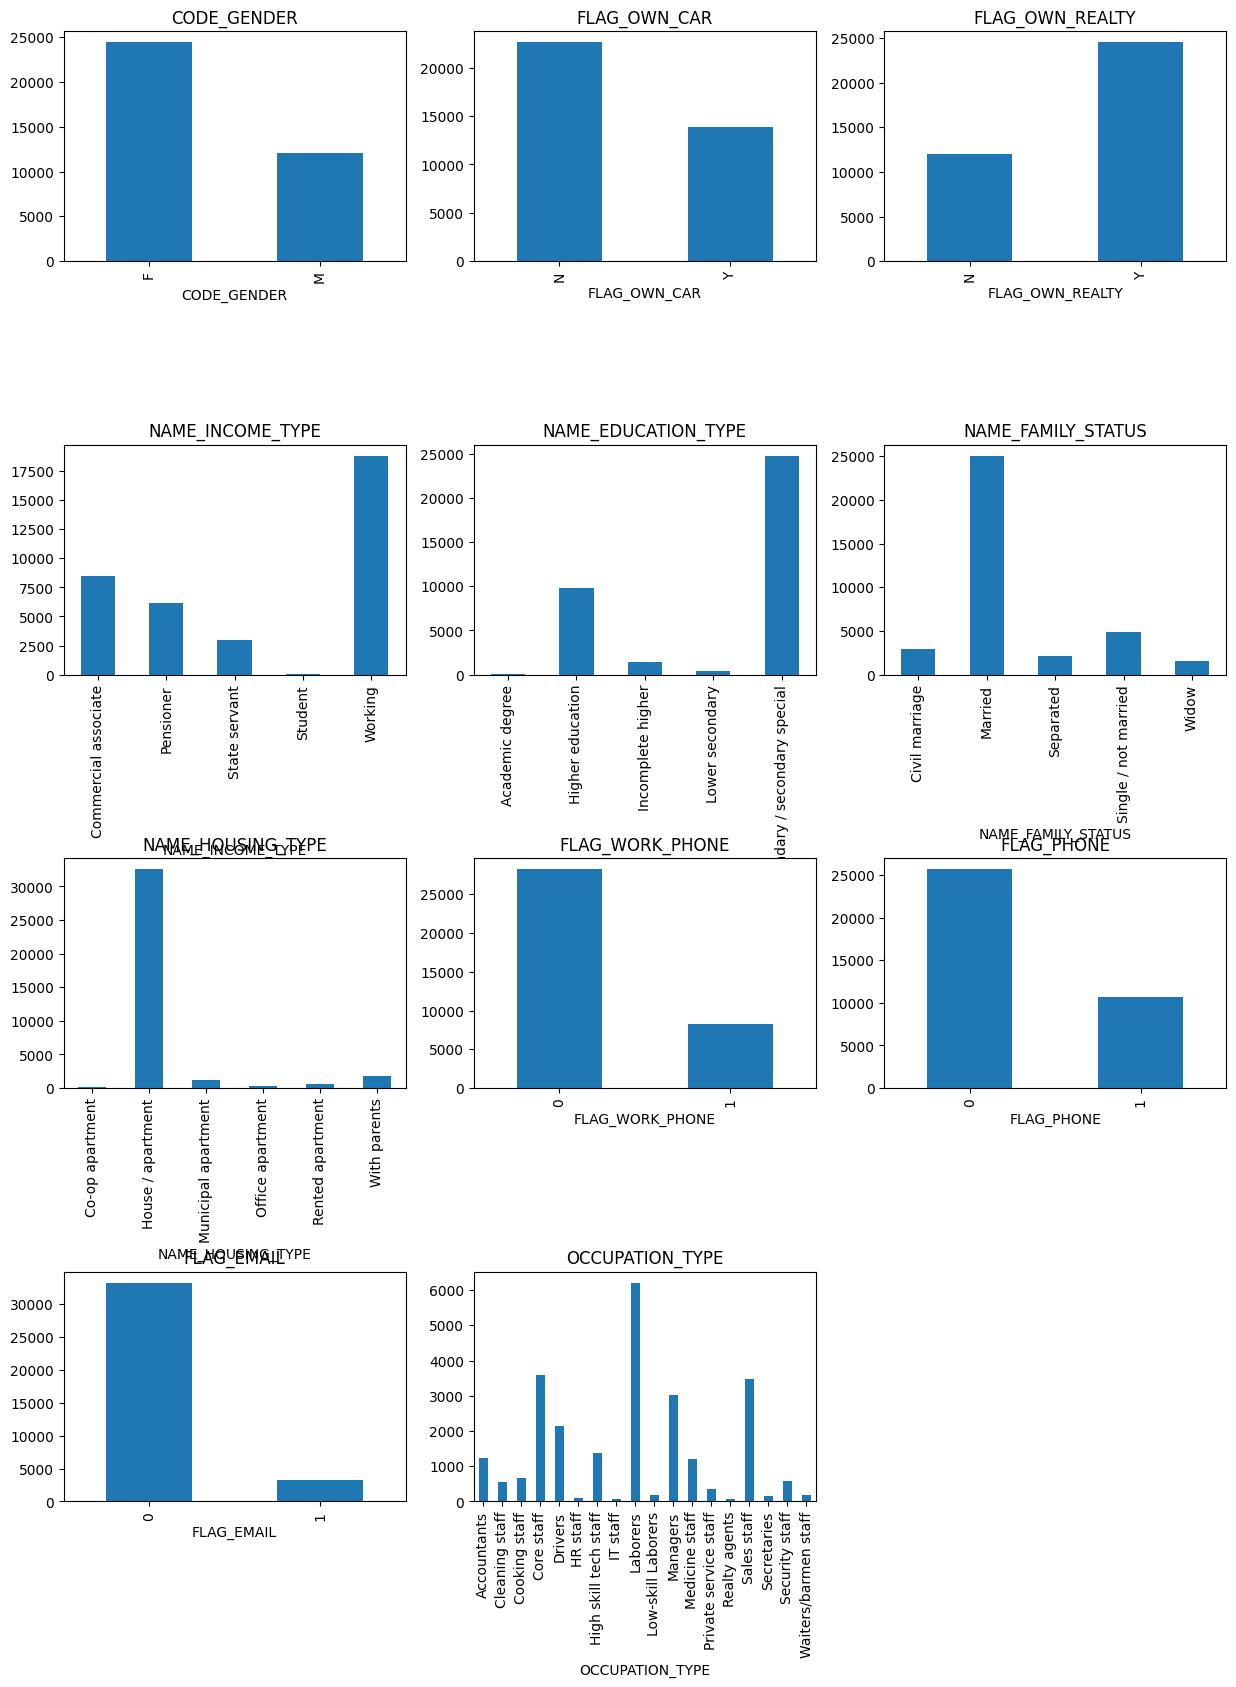

In [35]:
# cateogircla column 별 분포 확인
plt.figure(figsize=(15,15))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8, wspace=0.2)
for column_name in list_categorical_columns:
    plt.subplot(4,3,x)
    x = x+1
    df[column_name].value_counts().sort_index().plot(kind='bar')
    plt.title(column_name)
plt.show()

##### Target column과 categorical column 관계 분포 확인

<Axes: xlabel='CODE_GENDER'>

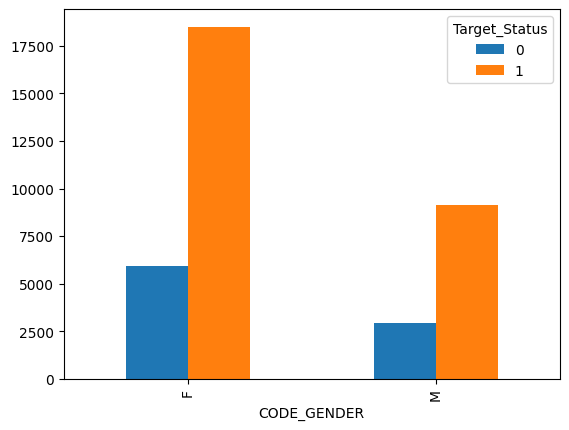

In [36]:
# categorical column과 dependent data(target column) 분포 분석
df_poutcome_dependent = pd.crosstab(df[list_categorical_columns[0]],df[target_column])
df_poutcome_dependent.plot(kind='bar')
# 애초에 target_column(Target_Status) 비중이 다르기 때문에, 아래와 같이 count 수를 비교하는 것은 데이터 분포를 파악하는데 적합하지 않음

In [37]:
##### to do #####
pd.crosstab(df[list_categorical_columns[0]], df[target_column], normalize='index')

Target_Status,0,1
CODE_GENDER,,
F,0.242448,0.757552
M,0.242371,0.757629


<Axes: xlabel='FLAG_OWN_CAR'>

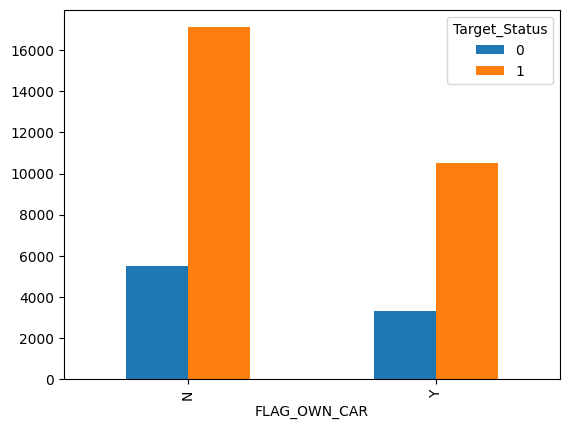

In [38]:
##### to do #####
# 성별은 Target_Status와 상관관계가 없어 보인다.
df_poutcome_dependent = pd.crosstab(df[list_categorical_columns[1]],df[target_column])
df_poutcome_dependent.plot(kind='bar')

<Figure size 3000x3000 with 0 Axes>

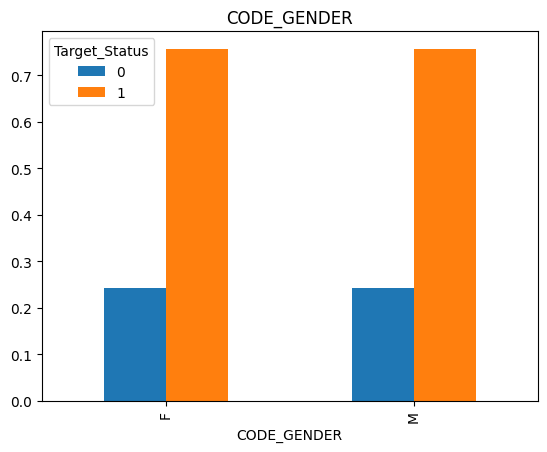

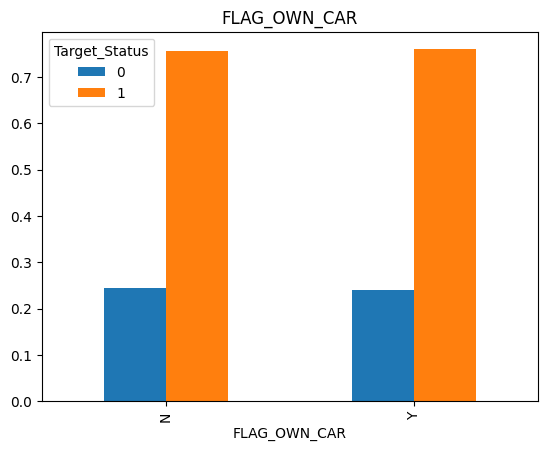

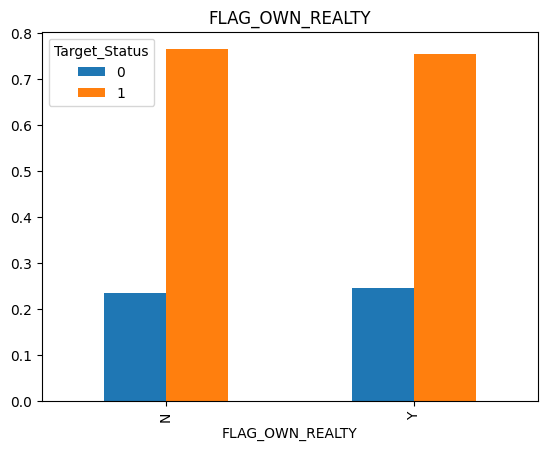

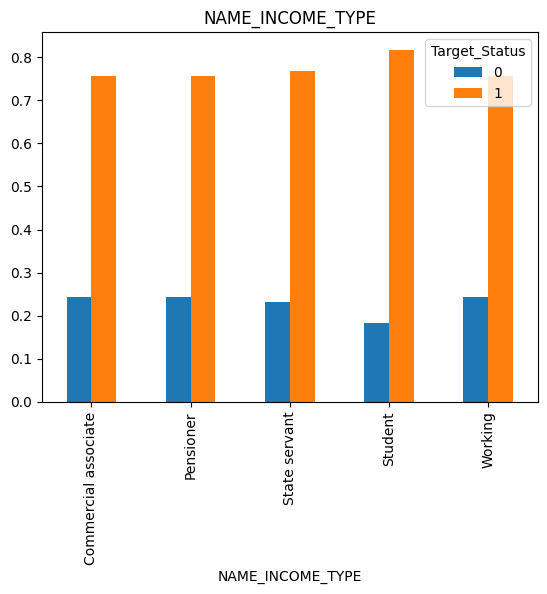

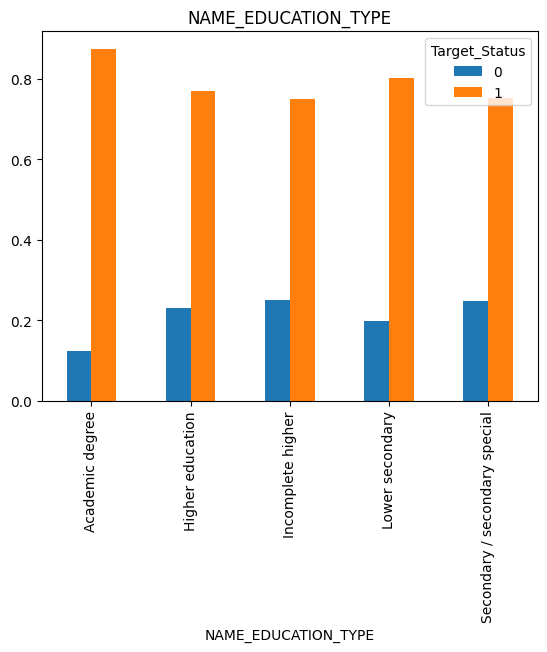

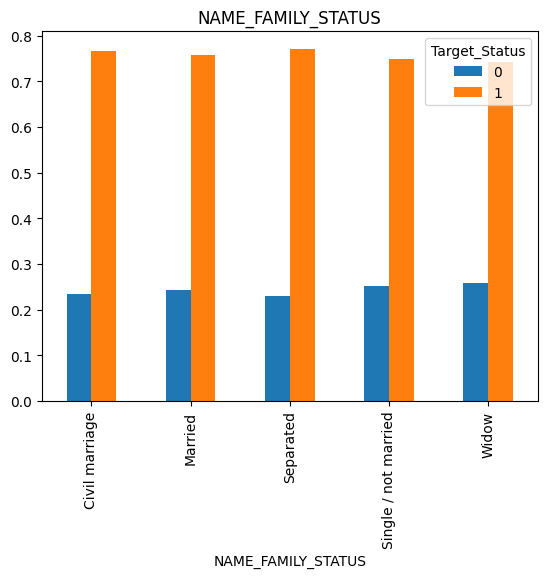

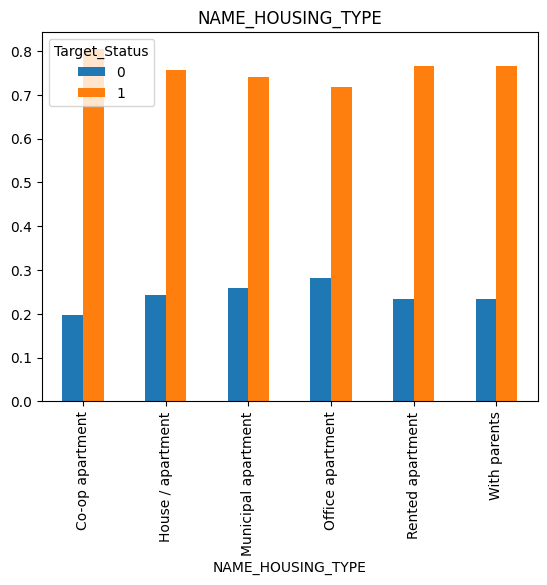

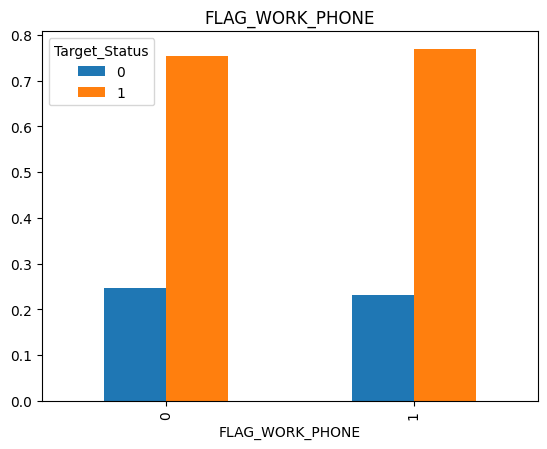

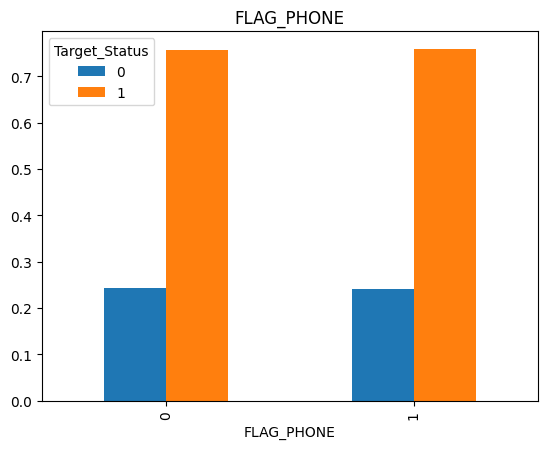

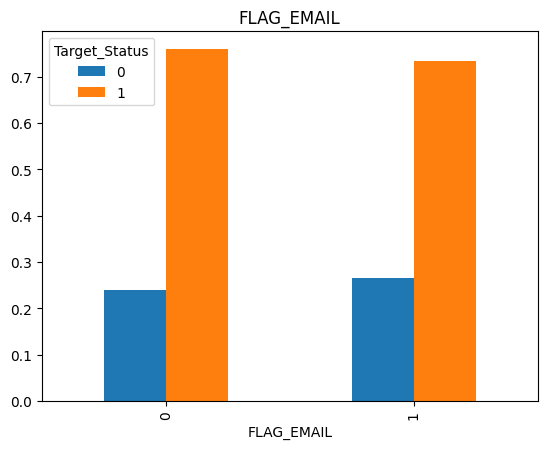

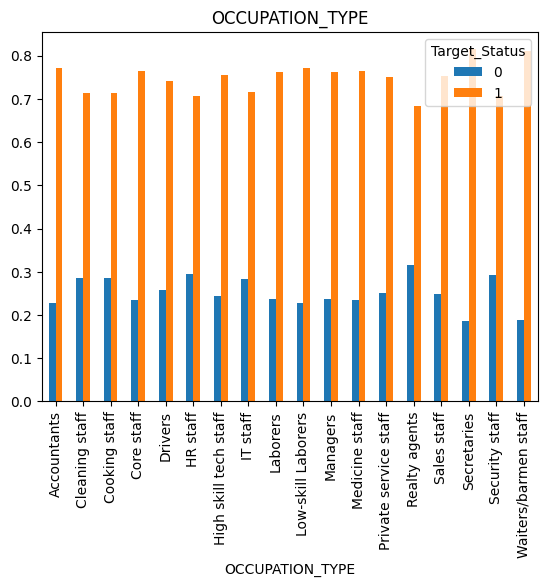

In [39]:
# 이런 경우에는 비율 데이터를 plot으로 그리면 데이터 분포 이해에 도움.

plt.figure(figsize=(30,30))
#plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8, wspace=0.2)
for column_name in list_categorical_columns:
    pd.crosstab(df[column_name], df[target_column], normalize="index").plot.bar()
    plt.title(column_name)
plt.show()

##### 카이제곱 검정 (chisqaure-test)
*   카이제곱 검정은 두 범주형 변수에 대한 분석 방법.
*   예를 들어, 성별에 따른 선호 영화 장르 비교 문제.
*   본 실습에서는 독립 변수중의 categorical column data와 y(target_status) 간의 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/카이제곱_검정



##### 카이제곱 검정 추가 설명 : 3가지 유형
1.   적합도 검정 (Goodness of fit)
  - 변수 1개
  - 기존에 알려준 기준이 존재하는 검정
  - 예시) 상자 안에 공 3개가 같은 비율로 알려져 있음. 공 100개를 뽑았을 때, 각 색의 비율이 구해짐. -> 기존에 알려진 공 비율 분포를 따르는지 검정
  - 귀무가설 : 변수 X의 관측분포와 기대 분포가 동일
  - 대립가설 : 변수 X의 관측분포와 기대분포가 동일

2.   독립성 검정 (Test of independence)
  - 변수 2개
  - 범주형 두 변수가 서로 연관되어 있는지 여부를 검정
  - 예시) 성별과 흡연 여부 관계를 알고 싶어서 200명을 추출하여 조사한 경우.
  - 귀무가설 : 변수 X와 Y는 서로 독립
  - 대립가설 : 변수 X와 Y는 서로 독립이 아님
3.   동질성 검정 (Test of Homogeneity)
  - 변수 2개
  - 범주형 두 변수의 관계를 알기 위한 검정은 아님
  - 각 그룹들이 동질한지 알고 싶은 검정
  - 예시) 남자와 여자 흡연율 차이가 있는지 흡연율을 조사한 후, 두 그룹의 흡연율이 같은지 여부를 검정
  - 귀무가설 : 각 그룹의 확률분포가 동일
  - 대립가설 : 각 그룹의 확률분포가 동일하지 않음




In [40]:
list_meaningful_column_by_chi = []
for column_name in list_categorical_columns:
    ##### to do #####
    stats_, pvalue, _, _ = chi2_contingency(pd.crosstab(df[target_column], df[column_name])) 
    if pvalue <= 0.05:
        list_meaningful_column_by_chi.append(column_name)

    print(column_name , ", ", stats_, ", ", pvalue)
print("all categorical columns : ", len(list_categorical_columns))
print("selected columns by chi : ", len(list_meaningful_column_by_chi), list_meaningful_column_by_chi)

CODE_GENDER ,  9.14917437672138e-06 ,  0.9975865942019964
FLAG_OWN_CAR ,  0.5098662708631283 ,  0.4751967521310614
FLAG_OWN_REALTY ,  4.977225226185185 ,  0.02568314470568055
NAME_INCOME_TYPE ,  2.01113474585598 ,  0.7337107708524153
NAME_EDUCATION_TYPE ,  18.572087173370093 ,  0.0009536101652285508
NAME_FAMILY_STATUS ,  7.550663604106124 ,  0.10949588140271563
NAME_HOUSING_TYPE ,  6.989183690226566 ,  0.2214459743899265
FLAG_WORK_PHONE ,  8.161893932932294 ,  0.004277967441616771
FLAG_PHONE ,  0.141973825352162 ,  0.7063265945457923
FLAG_EMAIL ,  10.15955131332863 ,  0.0014355555483766813
OCCUPATION_TYPE ,  37.75898732078343 ,  0.0026522066658164326
all categorical columns :  11
selected columns by chi :  5 ['FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE', 'FLAG_WORK_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE']


##### Insight
1.   y(종속 변수)와 categorical data 11개 중 5개만이 유의미한 관계를 갖음
2.   유의미한 관계를 갖는 categorical data를 feature selection하여 추후 ML 학습시 활용



#### 2) Numeric Data Analysis

##### 불필요한 컬럼 확인

In [41]:
#### to do ####
df[list_numeric_columns].nunique().sort_values()

CNT_CHILDREN           9
CNT_FAM_MEMBERS       10
MONTHS_BALANCE        61
AMT_INCOME_TOTAL     265
DAYS_EMPLOYED       3640
DAYS_BIRTH          7183
dtype: int64

In [42]:
df[list_numeric_columns].describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,MONTHS_BALANCE
count,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.000000,36457.000000
mean,0.430315,1.866857e+05,-15975.173382,59262.935568,2.198453,-5.831802
std,0.742367,1.017892e+05,4200.549944,137651.334859,0.911686,11.326494
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.000000,-60.000000
25%,0.000000,1.215000e+05,-19438.000000,-3153.000000,2.000000,-6.000000
50%,0.000000,1.575000e+05,-15563.000000,-1552.000000,2.000000,0.000000
75%,1.000000,2.250000e+05,-12462.000000,-408.000000,3.000000,0.000000
max,19.000000,1.575000e+06,-7489.000000,365243.000000,20.000000,0.000000


##### Column별 분포 확인

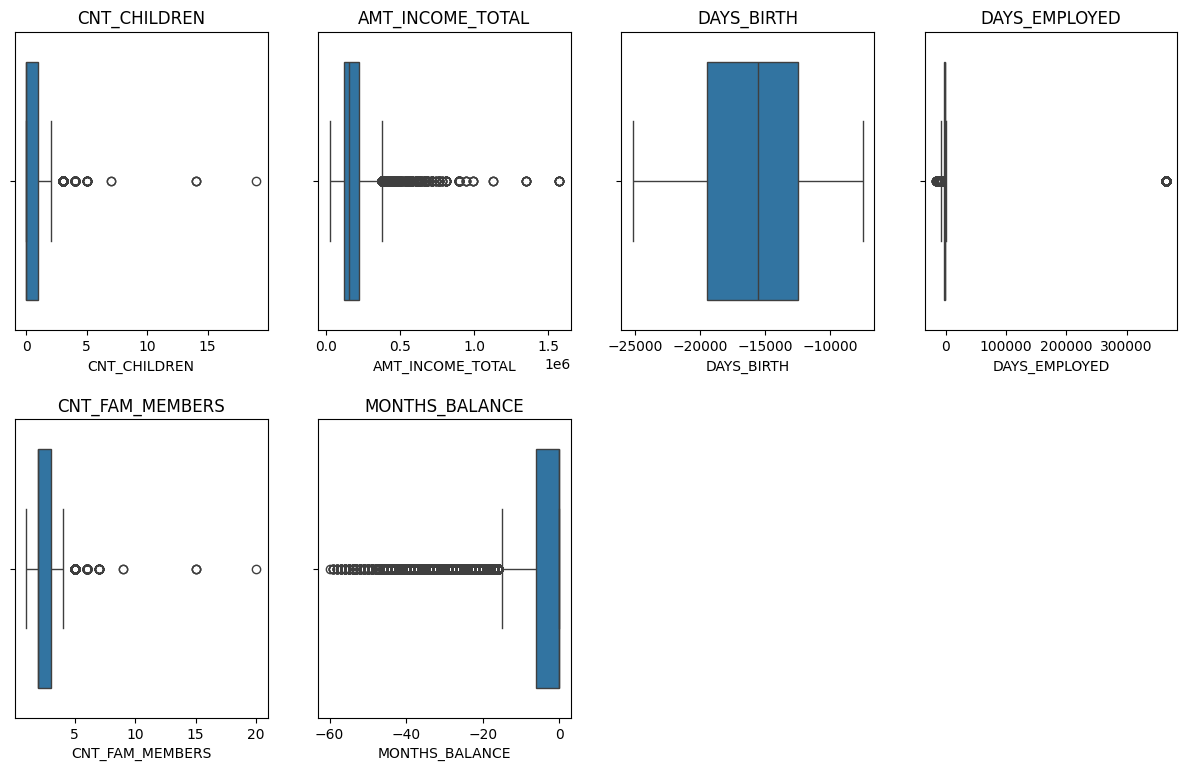

In [43]:
# numeric column 별 분포 확인
plt.figure(figsize=(15,7))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(2,4,x)
    x = x+1
    sns.boxplot(x=column_name, data=df)
    plt.title(column_name)
plt.show()

In [44]:
for column_name in list_numeric_columns:
  print(column_name, "skew : ", skew(df[column_name]), "kur : ", kurtosis(df[column_name]) )

# 추후 scaling을 활용한 feature preprocessing의 필요성 확인

CNT_CHILDREN skew :  2.5692764853112635 kur :  22.55917511845248
AMT_INCOME_TOTAL skew :  2.738897180151655 kur :  17.595506164509793
DAYS_BIRTH skew :  -0.18422206947290823 kur :  -1.045664746406706
DAYS_EMPLOYED skew :  1.7723702515885982 kur :  1.1430772697054437
CNT_FAM_MEMBERS skew :  1.298542476962789 kur :  8.187407769180325
MONTHS_BALANCE skew :  -2.1378871685624534 kur :  3.918957344284352


##### Correlation Analysis

<Axes: >

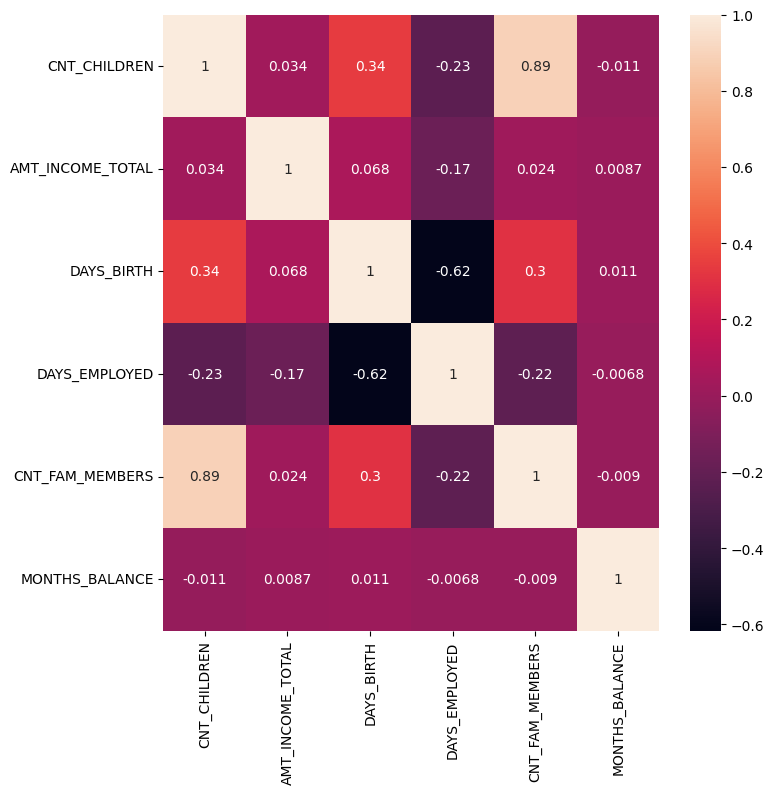

In [45]:
#### to do ####
plt.figure(figsize=(8,8))
df_corr = df[list_numeric_columns].corr()
sns.heatmap(df_corr, annot=True)

In [46]:
# CNT_FAM_MEMBERS와 CNT_CHILDREN이 상관관계가 높음
# 상식적으로 두개는 상관관계가 높을 것이라 판단됨

# 너무 높은 correlation을 갖는 데이터를 삭제. 단, 해당 correlation값을 신뢰할 수 있는지 확인필요
# 기준은 절대값 0.85 이상

#### to do ####
index_corr_over_85 = np.where((abs(df_corr)>0.85)&(df_corr != 1))
index_corr_over_85

(array([0, 4]), array([4, 0]))

In [47]:
# correlation이 0.85 이상인 경우의 pvalue 검정
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

# To do
# pearson correlations 

statistic, pvalue = stats.pearsonr(df.loc[:,'CNT_FAM_MEMBERS'], df.loc[:,'CNT_CHILDREN'])
print(statistic)
print(pvalue)

0.8891141560150977
0.0


##### VIF Analysis
-   일반적으로는는 10이상인인 경우 다중공선성이이 있다고 가정
-   high correlation 컬럼을 제거하기 전에 한 번 더 검정을 진행 (doublecheck, 개인의 판단에 따라서 진행하지 않아도됨)

In [48]:
# caculate_vif function
def caculate_vif(df_target):
  vif = pd.DataFrame()
  vif["VIF_Factor"] = [variance_inflation_factor(df_target.values, i) for i in range(df_target.shape[1])]
  vif["Feature"] = df_target.columns
  return vif

df_vif = df[list_numeric_columns].copy()

In [49]:
# To do
# VIF Factor
caculate_vif(df[list_numeric_columns])

,VIF_Factor,Feature
0,5.501891,CNT_CHILDREN
1,4.177863,AMT_INCOME_TOTAL
2,13.927450,DAYS_BIRTH
3,1.814530,DAYS_EMPLOYED
4,20.422667,CNT_FAM_MEMBERS
5,1.259641,MONTHS_BALANCE


In [50]:
# To do 
# remove CNT_FAM_MEMBERS 
caculate_vif(df[list_numeric_columns].drop('CNT_FAM_MEMBERS', axis=1))

,VIF_Factor,Feature
0,1.317477,CNT_CHILDREN
1,4.030542,AMT_INCOME_TOTAL
2,5.406126,DAYS_BIRTH
3,1.665757,DAYS_EMPLOYED
4,1.256456,MONTHS_BALANCE


In [51]:
list_numeric_feature_by_vif = list_numeric_columns.copy()
list_numeric_feature_by_vif.remove("CNT_FAM_MEMBERS")

In [52]:
list_numeric_feature_by_vif

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'MONTHS_BALANCE']

##### Target Column과 numeric Column 관계 분포 확인

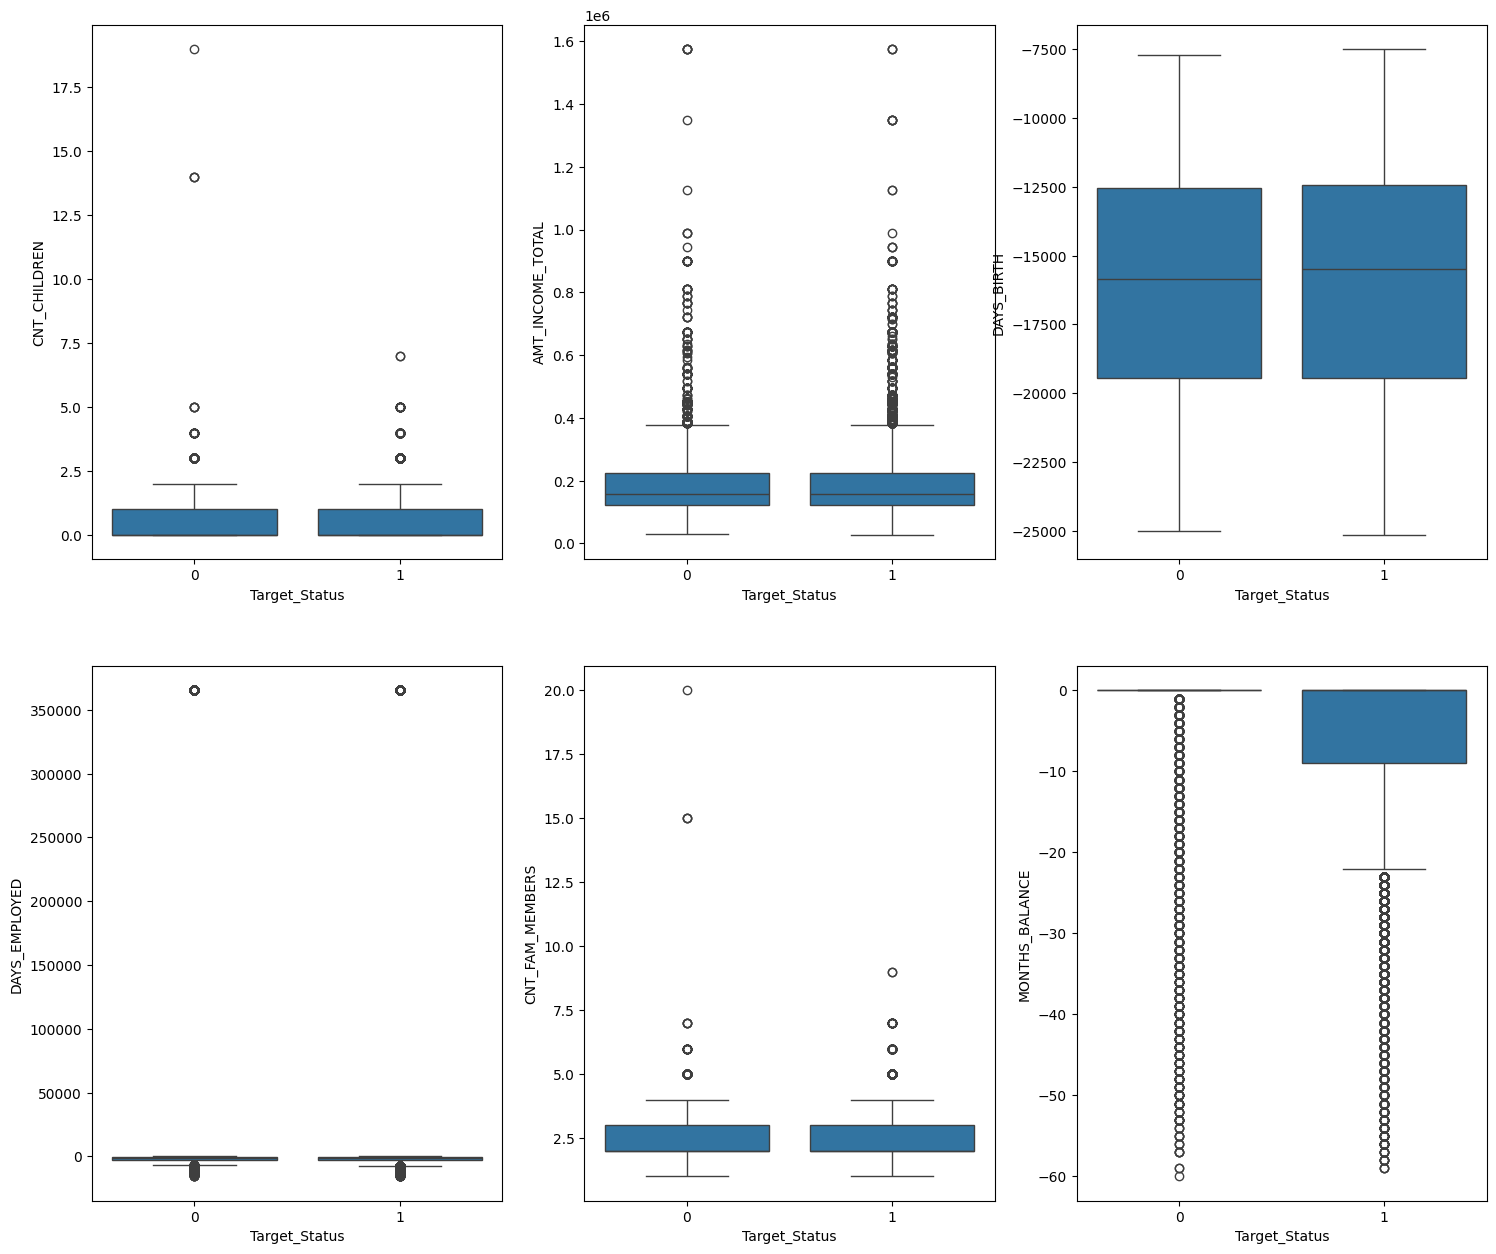

In [53]:
plt.figure(figsize=(18,12))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(2,3,x)
    x = x + 1
    sns.boxplot(data=df,x=target_column,y=column_name)
plt.show()

# month_balance 차이가 보임

##### 일원분산분석 (ANOVA)
*   카테고리별 numeric data 분포 차이를 검증
*   전제 : 정규성, 등분산성, 독립성 (만족하지 않으면 해당 검정을 신뢰할 수 없음)
*   본 실습에서는 target_status 에 따른 numeric column data 분포 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/분산_분석#일원분산분석(one-way_ANOVA)





정규성 검정
*   귀무가설 : 모집단의 분포는 정규 분포이다
*   검정 방법 : Shpiro-Wilks Test, qqplot
*   p-value < 0.05이면, 귀무가설 기각 (기각하지 못하여야 정규성을 만족)

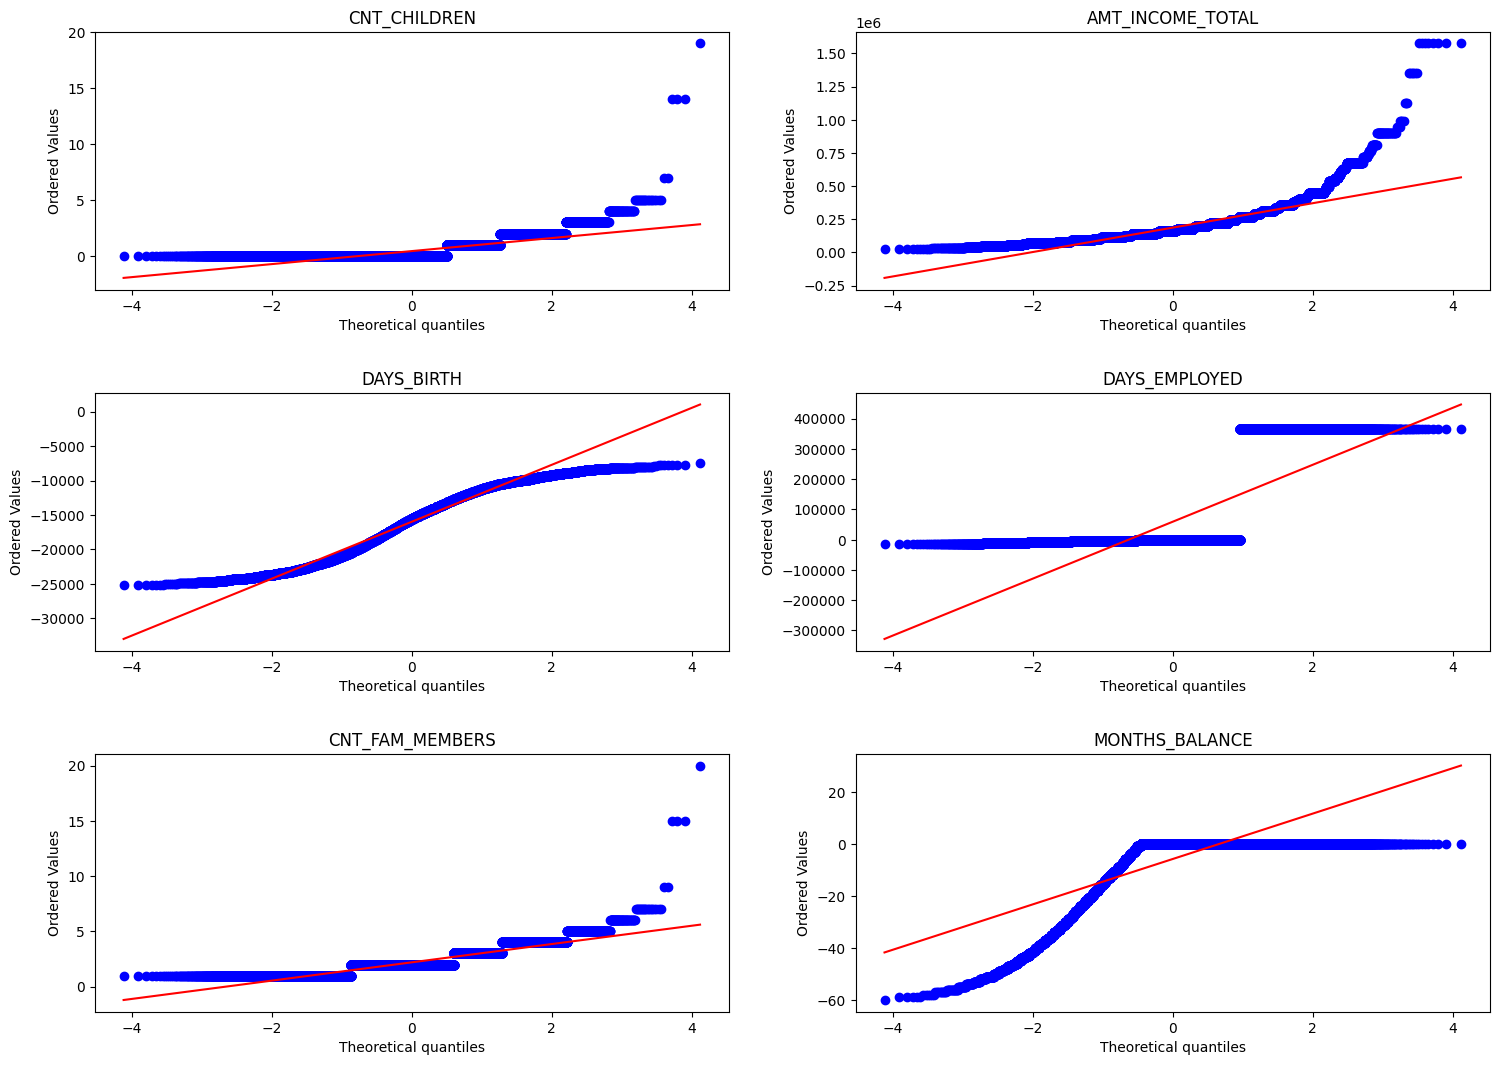

In [54]:
# numeric column 정규성 확인
plt.figure(figsize=(18,10))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(3,2,x)
    x = x+1
    stats.probplot(df[column_name], dist=stats.norm, plot=plt)
    plt.title(column_name)
plt.show()

In [55]:
list_column_normality = []
for column_name in list_numeric_columns:
  statistic, pvalue = stats.shapiro(df[column_name])
  if pvalue >= 0.05:
    list_column_normality.append(column_name)
  print(column_name, ", statistic : ", statistic, ", pvalue : ", pvalue)

print("정규성 만족하는 column 수 : ",len(list_column_normality))

CNT_CHILDREN , statistic :  0.6152937705806764 , pvalue :  2.2142495006863838e-125
AMT_INCOME_TOTAL , statistic :  0.8168496452628089 , pvalue :  4.158438860652268e-105
DAYS_BIRTH , statistic :  0.9662971117063945 , pvalue :  1.169202152116439e-65
DAYS_EMPLOYED , statistic :  0.4661093440770788 , pvalue :  6.535805462011858e-135
CNT_FAM_MEMBERS , statistic :  0.8236549801777466 , pvalue :  4.0234495421358244e-104
MONTHS_BALANCE , statistic :  0.5919125781999086 , pvalue :  4.524659155950108e-127
정규성 만족하는 column 수 :  0


/opt/homebrew/Caskroom/miniforge/base/envs/Mlops_prod/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 36457.
  res = hypotest_fun_out(*samples, **kwds)


정규성 만족하지 못함
*   정규성을 만족하지 못하므로, 등분산성 검정이 필요가 없음 (등분산성은 정규성을 전제)
*   일원분산분석을 통한 numeric data 검정 불가

##### 크루스칼 왈리스 검정 Kruskall-Wallis test (비모수 검정)
*   비모수 검정이기 때문에 정규성/등분산성을 만족하지 않아도됨
*   단, 비모수 검정이기 때문에 검정 결과 신뢰도가 모수 검정보다 떨어짐

In [56]:
list_target_unique = df[target_column].unique()
list_meaningful_column_by_kruskall = []

for column_name in list_numeric_columns:
  list_by_quality_value = []
  for quality_value in list_target_unique:
      df_tmp = df[df[target_column] == quality_value][column_name].dropna()
      list_by_quality_value.append(np.array(df_tmp))
  
  # To do 
  stats_ , pvalue = kruskal(*list_by_quality_value)
  if pvalue <= 0.05:
     list_meaningful_column_by_kruskall.append(column_name)
  
  print(column_name, ", ",statistic,", ", pvalue)
print("all numerical columns : ", len(list_numeric_columns))
print("selected columns by kruskal : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

CNT_CHILDREN ,  0.5919125781999086 ,  0.3338777062159171
AMT_INCOME_TOTAL ,  0.5919125781999086 ,  0.46293637094856877
DAYS_BIRTH ,  0.5919125781999086 ,  0.14409310721209023
DAYS_EMPLOYED ,  0.5919125781999086 ,  4.370195260220316e-07
CNT_FAM_MEMBERS ,  0.5919125781999086 ,  0.33263571559306976
MONTHS_BALANCE ,  0.5919125781999086 ,  1.280009852962771e-207
all numerical columns :  6
selected columns by kruskal :  2 ['DAYS_EMPLOYED', 'MONTHS_BALANCE']


##### Insight
1.   y(종속 변수)와 numerical data는 2개만이 유의미한 관계를 갖음 (크루스칼 왈리스 검정). (개인마다 다른 의사결정이 다를 수 있음, 실험을 통한 최적화 필요)
2.   상관관계가 매우 높으면서 VIF도 높은 변수가 존재하여, 데이터를 제거할 예정 ("CNT_FAM_MEMBERS")


## 3. Data Processing 2

### 3-1 Feature Selection
*   카이제곱 검정을 통과한 categorical 선택
*   kruskall 검정 통과한 numerical 선택
*   correlation에서 상관관계가 높다고 판단한 numericla data 제거



In [57]:
list_selected_numerical = list_meaningful_column_by_kruskall.copy()

In [58]:
df_fs = df[list_meaningful_column_by_chi + list_selected_numerical + [target_column]]
df_fs.head(2)

,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,FLAG_WORK_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,DAYS_EMPLOYED,MONTHS_BALANCE,Target_Status
0,Y,Higher education,1,0,NaN,-4542,0,1
1,Y,Higher education,1,0,NaN,-4542,0,1


### 3-2 Missing Values

In [59]:
df_fs.isna().sum()

FLAG_OWN_REALTY            0
NAME_EDUCATION_TYPE        0
FLAG_WORK_PHONE            0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
DAYS_EMPLOYED              0
MONTHS_BALANCE             0
Target_Status              0
dtype: int64

In [60]:
df["OCCUPATION_TYPE"]

0                   NaN
1                   NaN
2        Security staff
3           Sales staff
4           Sales staff
              ...      
36452          Managers
36453    Medicine staff
36454    Medicine staff
36455       Sales staff
36456          Laborers
Name: OCCUPATION_TYPE, Length: 36457, dtype: object

### 3-3 Feature Transformation

In [61]:
# To do 
Y = df_fs[target_column]
X = df_fs.drop([target_column], axis=1)

In [62]:
Y

0        1
1        1
2        1
3        0
4        1
        ..
36452    0
36453    1
36454    1
36455    0
36456    0
Name: Target_Status, Length: 36457, dtype: object

##### Label Encoding

In [63]:
# object를 int64 형 변환만 완료하면 됨.
# astype('int64')를 쓰거나 아래 labelencoder를 쓰면됨. astype이 효율적이지만, 이번 실습에서는 LabelEncoder를 써보도록 진행.
le = LabelEncoder()
le.fit(Y)
Y_encoded = le.transform(Y)

In [64]:
Y_encoded

array([1, 1, 1, ..., 1, 0, 0])

In [65]:
type(Y_encoded[0])

numpy.int64

##### Feature Scaling
*   Standardization과 MinMaxScaling은 다른 것.
*   MinMaxScaling은 [0,1]로 값을 scaling 하는 것 (예 sklearn의 MinMaxScaler())
*   Standardization은 정규분포의 표준화를 활용하여 scaling하는 것 (예 sklearn의 StandardScaler())



In [66]:
list_categorical_columns = list(df_fs.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df_fs.select_dtypes(include=['float64','int64']).columns)
print(len(list_categorical_columns))
print(len(list_numeric_columns))

6
2


In [73]:
X.columns

Index(['FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE', 'FLAG_WORK_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'DAYS_EMPLOYED', 'MONTHS_BALANCE'],
      dtype='object')

In [77]:
### to do ###
# minmaxscaling
scaler = MinMaxScaler()
X.loc[:, list_selected_numerical] = scaler.fit_transform(X[list_selected_numerical])
X.head(1)

/var/folders/1l/w3vzbf215cs4ll30rh71l7wr6ghggx/T/ipykernel_38305/1181407326.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0293236  0.0293236  0.03826951 ... 0.03776814 0.03952687 0.03811464]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, list_selected_numerical] = scaler.fit_transform(X[list_selected_numerical])
/var/folders/1l/w3vzbf215cs4ll30rh71l7wr6ghggx/T/ipykernel_38305/1181407326.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1. 1. 1. ... 1. 1. 1.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, list_selected_numerical] = scaler.fit_transform(X[list_selected_numerical])


,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,FLAG_WORK_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,DAYS_EMPLOYED,MONTHS_BALANCE
0,Y,Higher education,1,0,NaN,0.029324,1.0


##### One-hot Encoding for categorical column data

In [78]:
X_base = pd.get_dummies(X)
X_base.head(1)

,DAYS_EMPLOYED,MONTHS_BALANCE,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,FLAG_WORK_PHONE_0,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,0.029324,1.0,False,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 3-4 Sampling
*   이번 실습에서는 한 가지 oversampling 기법과 combinedsampling 기법을 활용하고, 이를 활용하여 Model optimization 진행
*   SMOTE : Synthetic Minority Overf-sampling Technique. minority class에서 synthetic sampling을 생성하는 방법. 특정 minority class A에서 knn 기준으로 가까운 minority class Set K를 생성하고, A와 Set K 사이 간에 새로운 관측치를 생성하는 기법.
*   SMOTEENN : SMOTE + ENN



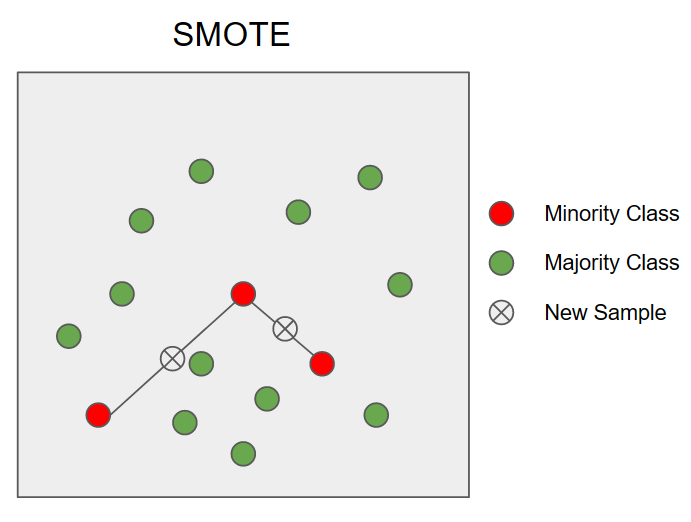

In [80]:
Image(path_lecture+"img/sampling.png")

In [81]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y_encoded, test_size=0.2, stratify=Y_encoded)

SMOTE

In [82]:
### to do ###
# smote oversampling

sm  = SMOTE(random_state=random_state)
X_sm_sampling, y_sm_sampling = sm.fit_resample(X_train, y_train)

In [94]:
y_train

array([1, 1, 1, ..., 0, 1, 1])

SMOTEENN

In [100]:
combined_sm = SMOTEENN(random_state=random_state)
X_csm_sampling, y_csm_sampling = combined_sm.fit_resample(X_train, y_train)

### 3-3 Summary
##### 최종 생성 Feature는 아래와 같은 특성을 가짐
1.   Feature Selection by Chi-test, correlation and kruskal-test
2.   Feature Transformation
3.   Sampling (oversampling, combiedsampling)

##### Feature 종류
1.   X_base, Y_encoded (No sampling, imbalanced data)
2.   X_sm_sampling, Y_sm_sampling (smote oversampling)
3.   X_csm_sampling, y_csm_sampling (smoteenn combinedsampling)

## 4. Model Analysis
1.   base model without sampling
2.   model optimization with base feature
3.   model optimization with smote oversampling
4.   model optimization with smoteenn combined sampling

In [102]:
list_model_type = []
list_model_best_params = []
list_model_f1_score = []
cv = 3
n_iter_randomsearch = 40

### 4-1. Base model without sampling

In [103]:
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_train, y_train)

3

In [104]:
# To do
# mlflow settings
import mlflow
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.create_experiment('credict_approval_ml_fc')

'339794461039389529'

In [105]:
# To do
# mlflow set experiment 
mlflow.set_experiment('credict_approval_ml_fc')

<Experiment: artifact_location='mlflow-artifacts:/339794461039389529', creation_time=1723602484012, experiment_id='339794461039389529', last_update_time=1723602484012, lifecycle_stage='active', name='credict_approval_ml_fc', tags={}>

In [106]:
# To do
# mlflow set autologging 
mlflow.sklearn.autolog()

In [107]:
list_fold_result = []
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    X_train_cv, X_test_cv = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
    rf_clf = MLPClassifier(hidden_layer_sizes=10)
    rf_clf.fit(X_train_cv, y_train_cv)
    y_prd_test = rf_clf.predict(X_test_cv)
    y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:,-1]
    prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average="macro")
    score_test = roc_auc_score(y_test_cv, y_prd_proba_test)
    print(i, " precision, recall, f1score : ", prf_score_test)
    print(i, " roc_auc_score : ", score_test)

    y_prd_validation = rf_clf.predict(X_validation)
    y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:,-1]
    prf_score_validation = precision_recall_fscore_support(y_validation, y_prd_validation, average="macro")
    score_validation = roc_auc_score(y_validation, y_prd_proba_validation)
    print("validation : precision, recall, f1score : ",prf_score_validation)
    print("validation : roc_auc_score : ",score_validation)
    list_fold_result.append(prf_score_validation[2])
    mlflow.log_param("feature_type", "base feature")

f1score_final = np.mean(list_fold_result)
print("average roc auc score : ",f1score_final)
list_model_type.append("Base model without sampling")
list_model_best_params.append({})
list_model_f1_score.append(f1score_final)

2024/08/14 11:28:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ea5f70fe106947829b8f5b6dc253a1dc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/08/14 11:29:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/homebrew/Caskroom/miniforge/base/envs/Mlops_prod/lib/python3.10/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml"
2024/08/14 11:29:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run unleashed-hare-441 at: http://127.0.0.1:5000/#/experiments/339794461039389529/runs/ea5f70fe106947829b8f5b6dc253a1dc.
2024/08/14 11:29:00 INFO mlflow.tracking._tracking_service.client: 

0  precision, recall, f1score :  (0.4620900233292164, 0.4998726907557647, 0.4313113121634507, None)
0  roc_auc_score :  0.5872420295628196
validation : precision, recall, f1score :  (0.4342456557889759, 0.49955869246824225, 0.43126470606716155, None)
validation : roc_auc_score :  0.5826349377131792
1  precision, recall, f1score :  (0.37876761650036006, 0.49993211133740667, 0.43099613718834134, None)
1  roc_auc_score :  0.5843106622068107
validation : precision, recall, f1score :  (0.5037733260153677, 0.500011263069256, 0.4314884677105056, None)
validation : roc_auc_score :  0.5781284813123154
2  precision, recall, f1score :  (0.4412707196540719, 0.4997370034705053, 0.43126971520538093, None)
2  roc_auc_score :  0.5836125240174874
validation : precision, recall, f1score :  (0.3787213609548635, 0.4997284576393917, 0.4308905018340748, None)
validation : roc_auc_score :  0.5657621432269226
average roc auc score :  0.43121455853724733


<Axes: >

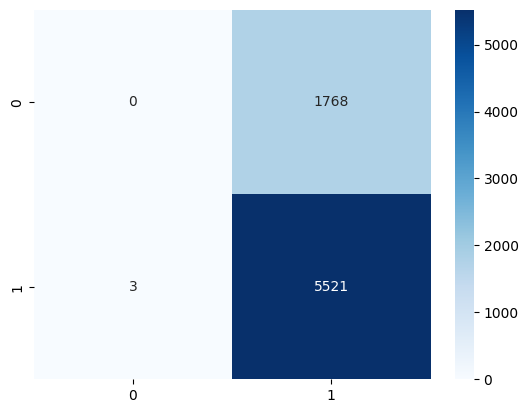

In [108]:
cm = pd.DataFrame(confusion_matrix(y_validation,y_prd_validation))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d')

### 4-2. model optimization with base feature

In [109]:
def plot_roc_auc(y_true, y_prd_proba):
    fpr, tpr, _ = roc_curve(y_true,  y_prd_proba)
    auc = roc_auc_score(y_true, y_prd_proba)
    plt.figure(figsize=(7,7))
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.legend(loc=4)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [110]:
mlflow.end_run()

2024/08/14 11:29:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run ambitious-boar-444 at: http://127.0.0.1:5000/#/experiments/339794461039389529/runs/dcb759e37da3406b988136e6540ec78e.
2024/08/14 11:29:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/339794461039389529.


In [111]:
def model_learning_with_randomsearch(model, hyper_parameter, X, Y, feature_type="base_feature",metric="roc_auc"):
    with mlflow.start_run():
        random_cv_opt = RandomizedSearchCV(estimator=model, param_distributions=hyper_parameter, n_iter=n_iter_randomsearch, cv = cv, random_state=random_state, scoring=metric, verbose=1)
        random_cv_opt.fit(X, Y)
        y_prd = random_cv_opt.predict(X_validation)
        mlflow.log_param("feature_type", feature_type)
        prf_score = precision_recall_fscore_support(y_validation, y_prd, average="macro")
        y_prd_proba = random_cv_opt.predict_proba(X_validation)[:,-1]
        score = roc_auc_score(y_validation, y_prd_proba)
        print('validation -> best model hyper-parameter : ', random_cv_opt.best_params_)
        print("validation -> precision, recall, f1score : ", prf_score)
        print("validation -> roc_auc_score : ", score)

        cm = pd.DataFrame(confusion_matrix(y_validation,y_prd))
        sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d')

    return random_cv_opt.best_params_, prf_score, prf_score[2]

/opt/homebrew/Caskroom/miniforge/base/envs/Mlops_prod/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 32 is smaller than n_iter=40. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/opt/homebrew/Caskroom/miniforge/base/envs/Mlops_prod/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024/08/14 11:29:46 INFO mlflow.sklearn.utils: Logging the 5 best runs, 27 runs will be omitted.
2024/08/14 11:29:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run fun-gull-913 at: http://127.0.0.1:5000/#/experiments/339794461039389529/runs/e7a9091914db46cf9d57730f4a0e48aa.
2024/08/14 11:29:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/339794461039389529.
2024/08/14 11:29:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run casual-snipe-221 at: http://127.0.0.1:5000/#/experiments/339794461039389529/runs/8eb125ed704d447dbc921d9b2575f5b4.
2024/08/14 11:29

validation -> best model hyper-parameter :  {'warm_start': False, 'solver': 'adam', 'power_t': 0.5, 'max_iter': 10000, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': 25, 'early_stopping': True, 'alpha': 0.0001, 'activation': 'relu'}
validation -> precision, recall, f1score :  (0.3787712561711465, 0.5, 0.43102372034956304, None)
validation -> roc_auc_score :  0.5767435333599824


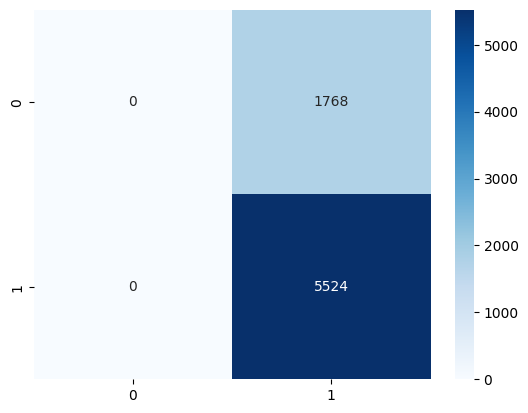

In [112]:
hyper_params_mlp = {
    'hidden_layer_sizes': [10, 15, 20, 25],
    'activation': ['tanh', 'relu'],
    'solver': ["sgd", "adam"],
    'learning_rate': ['constant'],
    'learning_rate_init': [0.001, 0.01],
    'power_t': [0.5],
    'alpha': [0.0001],
    'max_iter': [10000],
    'early_stopping': [True],
    'warm_start': [False]
              }

params, prf_score, score = model_learning_with_randomsearch(MLPClassifier(), hyper_params_mlp, X_base, Y_encoded, feature_type="base_feature")
list_model_type.append("model optimization with base feature")
list_model_best_params.append(params)
list_model_f1_score.append(score)

### 4-3. model optimization with smote oversampling

/opt/homebrew/Caskroom/miniforge/base/envs/Mlops_prod/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 32 is smaller than n_iter=40. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/opt/homebrew/Caskroom/miniforge/base/envs/Mlops_prod/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
2024/08/14 11:31:37 INFO mlflow.sklearn.utils: Logging the 5 best runs, 27 runs will be omitted.
2024/08/14 11:31:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-ox-428 at: http://127.0.0.1:5000/#/experiments/339794461039389529/runs/a1ecc81771c747628c74e1bc3eeb3033.
2024/08/14 11:31:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/339794461039389529.


2024/08/14 11:31:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run big-boar-721 at: http://127.0.0.1:5000/#/experiments/339794461039389529/runs/b358be2b04464f99a5111dee4be7784b.
2024/08/14 11:31:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/339794461039389529.
2024/08/14 11:31:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run brawny-dog-175 at: http://127.0.0.1:5000/#/experiments/339794461039389529/runs/07e796370cf74063ae32c0bfe758eb9f.
2024/08/14 11:31:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/339794461039389529.
2024/08/14 11:31:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run painted-bug-244 at: http://127.0.0.1:5000/#/experiments/339794461039389529/runs/7b258c66fed249dd8d556a9f44812a73.
2024/08/14 11:31:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3397944610393

2024/08/14 11:31:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run unique-asp-952 at: http://127.0.0.1:5000/#/experiments/339794461039389529/runs/23b8f71b0d67466c8e8460ffd084877f.
2024/08/14 11:31:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/339794461039389529.
2024/08/14 11:32:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run blushing-calf-832 at: http://127.0.0.1:5000/#/experiments/339794461039389529/runs/b10acec50307423a8b6b95861e3b070b.
2024/08/14 11:32:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/339794461039389529.


validation -> best model hyper-parameter :  {'warm_start': False, 'solver': 'adam', 'power_t': 0.5, 'max_iter': 10000, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': 20, 'early_stopping': True, 'alpha': 0.0001, 'activation': 'relu'}
validation -> precision, recall, f1score :  (0.5626983501040005, 0.5752932084101953, 0.46297969870671984, None)
validation -> roc_auc_score :  0.5854952453465094


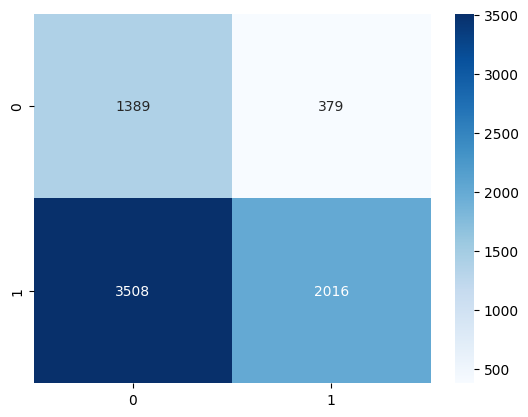

In [113]:
params, prf_score, score = model_learning_with_randomsearch(MLPClassifier(), hyper_params_mlp, X_sm_sampling, y_sm_sampling, feature_type="smote oversampling")
list_model_type.append("model optimization with smote oversampling")
list_model_best_params.append(params)
list_model_f1_score.append(score)

### 4-4. model optimization with smoteenn combined sampling

/opt/homebrew/Caskroom/miniforge/base/envs/Mlops_prod/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 32 is smaller than n_iter=40. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/opt/homebrew/Caskroom/miniforge/base/envs/Mlops_prod/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
2024/08/14 11:32:16 INFO mlflow.sklearn.utils: Logging the 5 best runs, 27 runs will be omitted.
2024/08/14 11:32:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run nervous-sheep-721 at: http://127.0.0.1:5000/#/experiments/339794461039389529/runs/b89bf38fb5674ef6a67e85f5027c179f.
2024/08/14 11:32:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/339794461039389529.


validation -> best model hyper-parameter :  {'warm_start': False, 'solver': 'adam', 'power_t': 0.5, 'max_iter': 10000, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': 20, 'early_stopping': True, 'alpha': 0.0001, 'activation': 'tanh'}
validation -> precision, recall, f1score :  (0.5266791550111108, 0.5293988633720073, 0.5269159518818294, None)
validation -> roc_auc_score :  0.5504884997919404


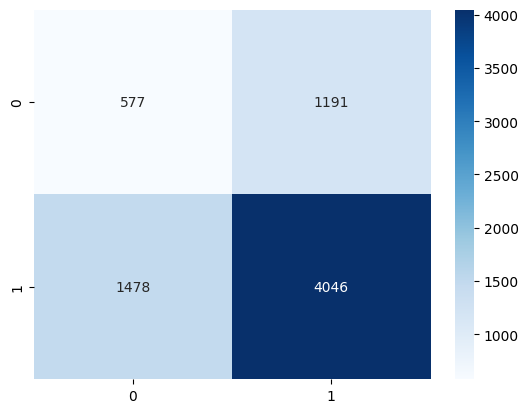

In [114]:
params, prf_score, score = model_learning_with_randomsearch(MLPClassifier(), hyper_params_mlp, X_csm_sampling, y_csm_sampling, feature_type="smoteenn combined sampling")
list_model_type.append("model optimization with smoteenn combined sampling")
list_model_best_params.append(params)
list_model_f1_score.append(score)

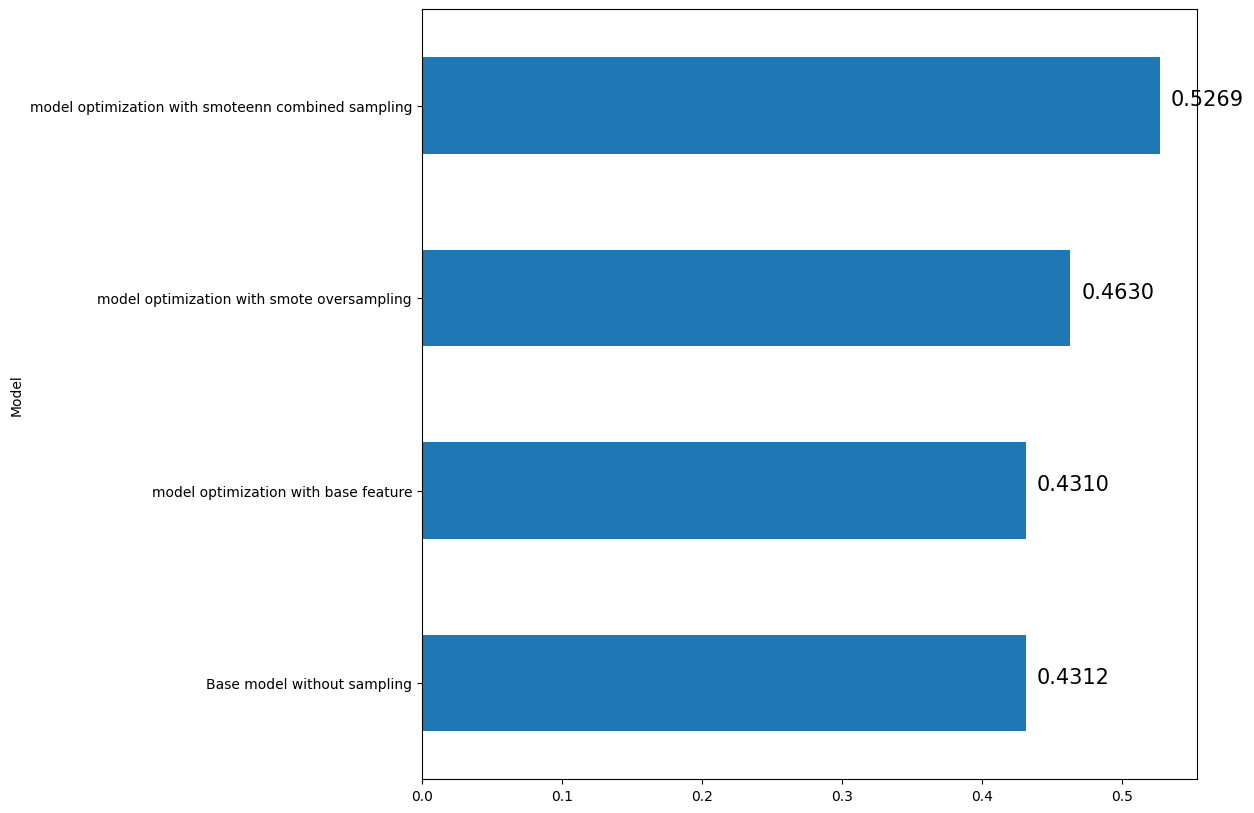

In [115]:
df_metric = pd.DataFrame({'Model':list_model_type, 'f1score_macro':list_model_f1_score})
ax = df_metric.plot.barh(x='Model', y='f1score_macro', rot=0, figsize=(10,10), legend=False)
for bar in ax.patches:
    ax.annotate(format(bar.get_width(), '.4f'),
                   (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                   size=15, xytext=(8, 0),
                   textcoords='offset points')

### 4.6 Model Serving

In [116]:
# To do
# Load production models 

model_uri = "models:/credit_approval_mlp1/Staging"
loaded_model = mlflow.sklearn.load_model(model_uri)


/opt/homebrew/Caskroom/miniforge/base/envs/Mlops_prod/lib/python3.10/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


In [117]:
loaded_model

MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=20,
              learning_rate_init=0.01, max_iter=10000)

In [118]:
y_prd_production = loaded_model.predict(X_validation)

In [119]:
y_prd_production
prf_score_production = precision_recall_fscore_support(y_validation, y_prd_production, average="macro")
score_production = roc_auc_score(y_validation, y_prd_production)

print(prf_score_production)
print(score_production)

(0.5266791550111108, 0.5293988633720073, 0.5269159518818294, None)
0.5293988633720073


In [ ]:
# mlflow models serve -m /Users/a202304035/MLOPS_ProdML/mlflow_project/mlartifacts/339794461039389529/b89bf38fb5674ef6a67e85f5027c179f/artifacts/best_estimator -p 5001 --no-conda

In [120]:
import pandas as pd
import requests

# Define local host and endpoint url
host = "127.0.0.1"
url = f"http://{host}:5001/invocations"

# Create dictionary with pandas DataFrame in the split orientation
json_data = {"dataframe_split": X_validation[20:50].to_dict(orient="split")}

# Score model
response = requests.post(url, json=json_data)
print(f"\nPyfunc 'predict_interval':\n${response.json()}")



Pyfunc 'predict_interval':
${'predictions': [0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]}


### 4.7 Model Analysis

##### Shapley Value
*   게임 이론에 근거해서 만들어진 값 (https://ko.wikipedia.org/wiki/게임이론)
*   하나의 특성에 대한 중요도를 알기위해 여러 특성들의 조합을 구성하고 해당 특성의 유무에 따른 변화를 분석해서 얻어낸 값
*.  Explainable AI
*   https://en.wikipedia.org/wiki/Shapley_value



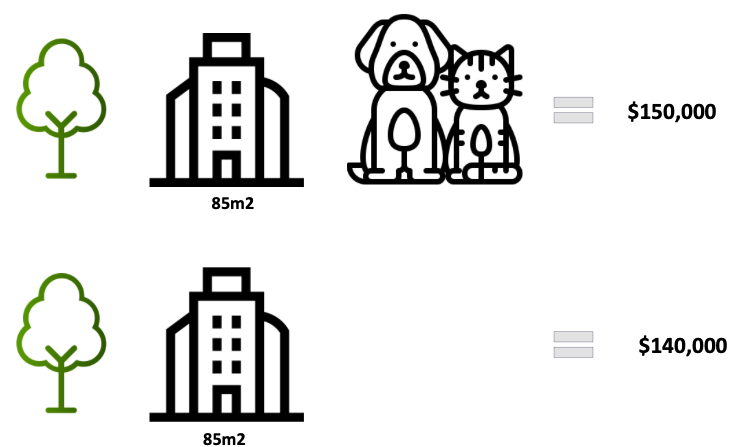

In [121]:
Image(path_lecture + "img/shapley_value.png")

In [122]:
mlp_final = MLPClassifier(**{'warm_start': False, 'solver': 'adam', 'power_t': 0.5, 'max_iter': 10000, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': 25, 'early_stopping': True, 'alpha': 0.0001, 'activation': 'relu'})
mlp_final.fit(X_csm_sampling, y_csm_sampling)

2024/08/14 11:46:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a4fff50e3a544a3da1acf936d7282874', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/08/14 11:46:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run adorable-boar-880 at: http://127.0.0.1:5000/#/experiments/339794461039389529/runs/a4fff50e3a544a3da1acf936d7282874.
2024/08/14 11:46:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/339794461039389529.


MLPClassifier(early_stopping=True, hidden_layer_sizes=25,
              learning_rate_init=0.01, max_iter=10000)

In [125]:
X_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7292 entries, 26312 to 17176
Data columns (total 31 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   DAYS_EMPLOYED                                      7292 non-null   float64
 1   MONTHS_BALANCE                                     7292 non-null   float64
 2   FLAG_OWN_REALTY_N                                  7292 non-null   bool   
 3   FLAG_OWN_REALTY_Y                                  7292 non-null   bool   
 4   NAME_EDUCATION_TYPE_Academic degree                7292 non-null   bool   
 5   NAME_EDUCATION_TYPE_Higher education               7292 non-null   bool   
 6   NAME_EDUCATION_TYPE_Incomplete higher              7292 non-null   bool   
 7   NAME_EDUCATION_TYPE_Lower secondary                7292 non-null   bool   
 8   NAME_EDUCATION_TYPE_Secondary / secondary special  7292 non-null   bool   
 9   FLAG_WOR

In [127]:
for c in X_validation.columns:
    X_validation[c] = X_validation[c].astype('float64')

In [ ]:
explainer = shap.Explainer(lambda x : mlp_final.predict_log_proba(x)[:,1], X_validation)
shap_values = explainer(X_validation)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


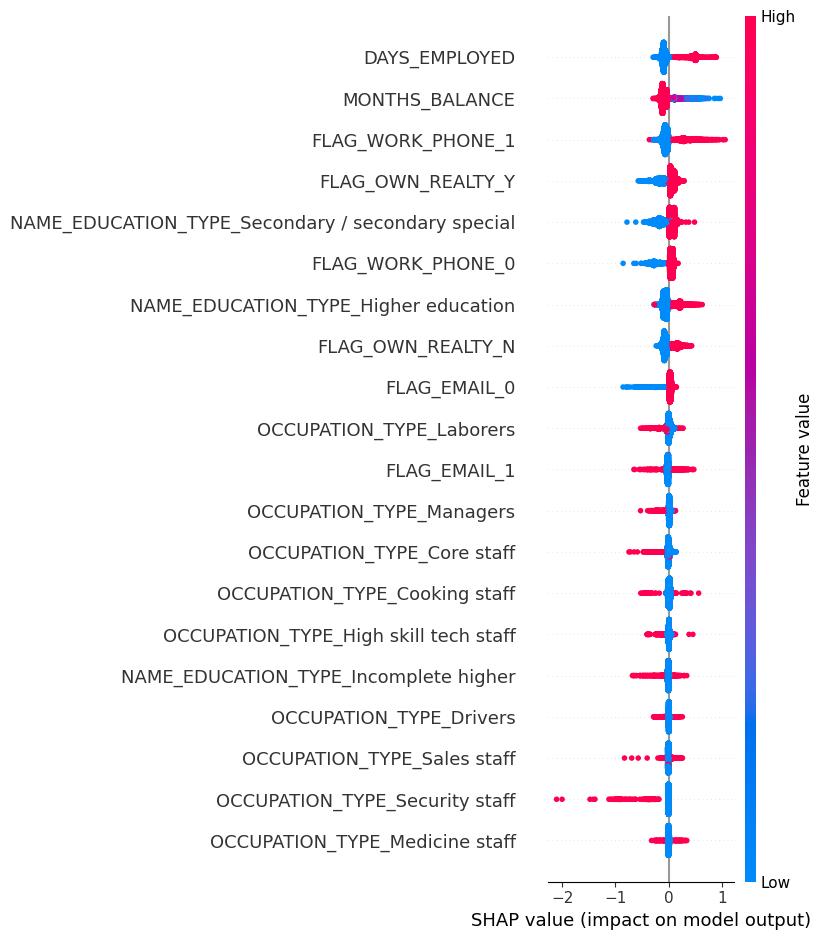

In [ ]:
shap.summary_plot(shap_values, X_validation)